DATASET ../IMDB-Dataset-GoogleTranslate-proccessed-nefnir.csv


/home/olafurj/dev/Lokaverkefni/sentiment-analysis/.env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      8229
           1       0.87      0.84      0.86      8271

    accuracy                           0.86     16500
   macro avg       0.86      0.86      0.86     16500
weighted avg       0.86      0.86      0.86     16500

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LinearSVC())])
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      8229
           1       0.88      0.90      0.89      8271

    accuracy                           0.89     16500
   macro avg       0.89      0.89      0.89     16500
weighted avg       0.89      0.89      0.89     16500

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      8229
           1       0

<Figure size 3200x1600 with 0 Axes>

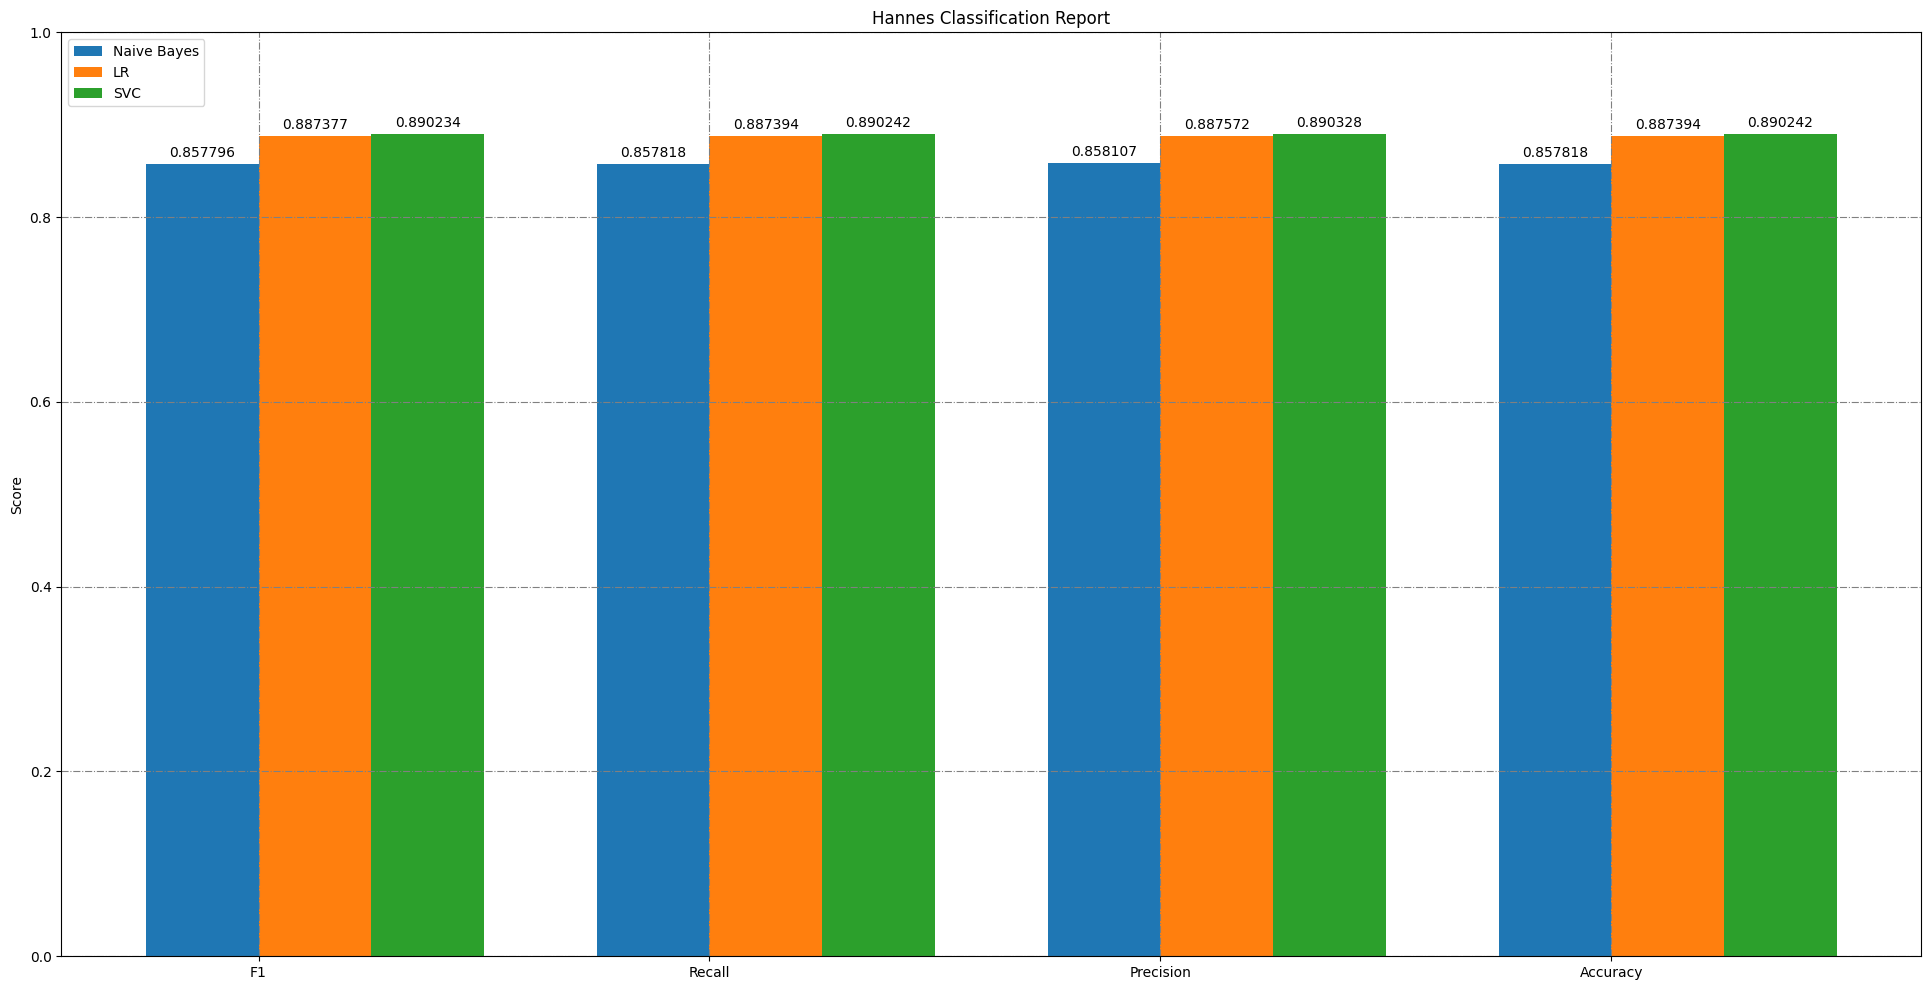

In [2]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def clear_df(data):
    if "Unnamed: 0" in data.columns:
        data.drop(["Unnamed: 0"], axis=1, inplace=True)    
    if "id" in data.columns:
        data.drop(["id"], axis=1, inplace=True)
    def convert(sentiment):
        return 1 if sentiment == 'positive' else 0
    data['sentiment'] = data.sentiment.apply(convert)
    review, sentiment = data["review"].values.astype('U'), data["sentiment"].to_numpy()
    return review, sentiment

def classify(path, train_path=None, eval_path=None):
    print("DATASET %s" % path)
    train_df, eval_df = None, None

    if train_path is not None and eval_path is not None:
        train_df = pd.read_csv(train_path)
        eval_df = pd.read_csv(eval_path)
        x_train, y_train = clear_df(train_df)
        x_test, y_test = clear_df(eval_df)
    else:
        data = pd.read_csv(path)
        review, sentiment = clear_df(data)
        x_train, x_test, y_train, y_test = train_test_split(
            review, sentiment, test_size=0.33, random_state=42
        )
    
    nb_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", MultinomialNB()),
        ]
    )
    svc_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LinearSVC()),
        ]
    )
    lr_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LogisticRegression()),
        ]
    )

    nb_pipeline.fit(x_train, y_train)
    svc_pipeline.fit(x_train, y_train)
    lr_pipeline.fit(x_train, y_train)

    predict_nb = nb_pipeline.predict(x_test)
    predict_svc = svc_pipeline.predict(x_test)
    predict_lr = lr_pipeline.predict(x_test)    
        
    f1_nb = f1_score(y_test, predict_nb, average="weighted")
    recall_nb = recall_score(y_test, predict_nb, average="weighted")
    prec_nb = precision_score(y_test, predict_nb, average="weighted")
    accuracy_nb = accuracy_score(y_test, predict_nb)

    f1_svc = f1_score(y_test, predict_svc, average="weighted")
    recall_svc = recall_score(y_test, predict_svc, average="weighted")
    prec_svc = precision_score(y_test, predict_svc, average="weighted")
    accuracy_svc = accuracy_score(y_test, predict_svc)

    f1_lr = f1_score(y_test, predict_lr, average="weighted")
    recall_lr = recall_score(y_test, predict_lr, average="weighted")
    prec_lr = precision_score(y_test, predict_lr, average="weighted")
    accuracy_lr = accuracy_score(y_test, predict_lr)

    print(nb_pipeline)
    print(classification_report(y_test, predict_nb))

    print(svc_pipeline)
    print(classification_report(y_test, predict_svc))

    print(lr_pipeline)
    print(classification_report(y_test, predict_lr))

    #return { "SVC": (1,2,3,4 ), "Naive Bayes": (1,2,3,4), "Logistic Regression": (1,2,3,4) }, ["F1", "Recall", "Precision", "Accuracy"]
    return ({ "Naive Bayes": (f1_nb, recall_nb, prec_nb, accuracy_nb), "LR": (f1_lr,recall_lr, prec_lr, accuracy_lr), "SVC": (f1_svc, recall_svc, prec_svc, accuracy_svc ) }, ["F1", "Recall", "Precision", "Accuracy"]), \
        nb_pipeline, svc_pipeline, lr_pipeline

def plot_f1(f1s, title):
    labels, values = f1s
    plt.figure(figsize=(32, 16))
    fig, ax = plt.subplots(figsize=(24,12)) #layout='constrained')
    plt.grid(color ='grey', linestyle ='-.')
    # for s in ['top', 'bottom', 'left', 'right']:
    #    ax.spines[s].set_visible(False)
    # ax.xaxis.set_ticks_position('none')
    # ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    #ax.xaxis.set_tick_params(pad = 5)
    #ax.yaxis.set_tick_params(pad = 10)
    x = np.arange(4)
    width = 0.25
    multiplier = 0
    # Add annotation to bars
    for attr, m in labels.items():
        offset = width * multiplier
        rects = ax.bar( x + offset, m, width, label=attr)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.set_xticks(x + width / 2, ("F1", "Recall", "Precision", "Accuracy"))
    plt.legend(loc='upper left')
    plt.savefig("%s.png" % title.replace(" ", "_"))
    ax.set_ylim(0, 1)
    
    plt.show()


#data = classify("../IMDB-Dataset-GoogleTranslate-Processed.csv")
#data2, nb_mideind, svc_mideind, lr_mideind = classify("../IMDB-Dataset-MideindTranslate-proccessed-nefnir.csv")
#data3, nb_google, svc_google, lr_google = classify("../IMDB-Dataset-GoogleTranslate-proccessed-nefnir.csv")
#data1, nb_english, svc_english, lr_english = classify("../IMDB-Dataset-Processed.csv")


data4, nb_hannes, svc_hannes, lr_hannes = classify(None, "../IMDB-Dataset-GoogleTranslate-proccessed-nefnir.csv", "../Hannes-Movie-Reviews-proccessed-nefnir-sentiment.csv")


#plot_f1(data1, "English Classification Report")
#plot_f1(data2, "Icelandic Miðeind Classification Report")
#plot_f1(data3, "Icelandic Google Classification Report")
plot_f1(data4, "Hannes Classification Report")





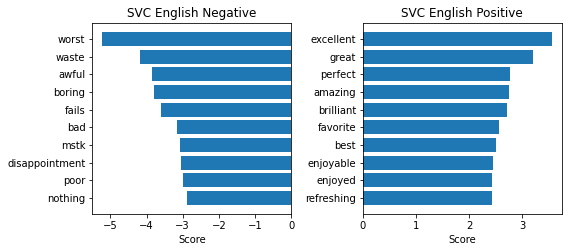

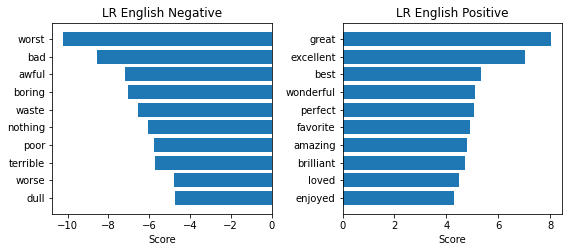

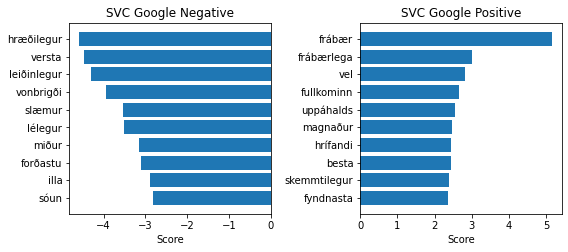

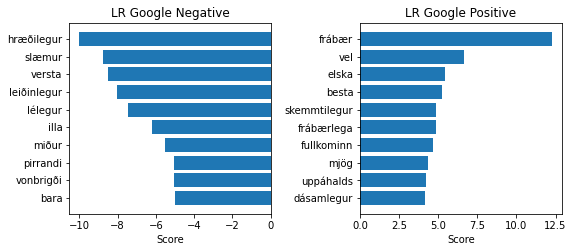

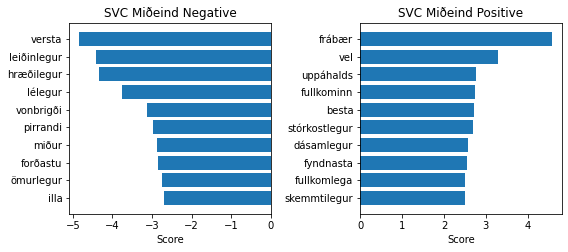

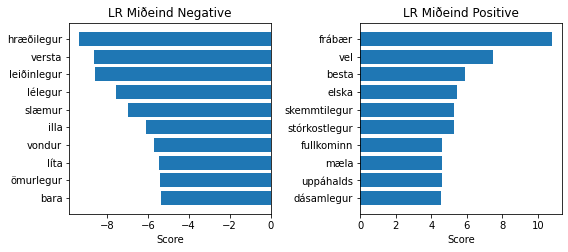

In [48]:


def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [
            (el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])
        ]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {"tops": tops, "bottom": bottom}
    return classes

def show_most_informative_features(vectorizer, clf, n=20):
    print(clf)
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.3f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


#show_most_informative_features(pipeline_2[0], pipeline_2[1], n=5)
#show_most_informative_features(logistic_regression_pipeline[0], logistic_regression_pipeline[1], n=10)


def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(3.6)
    
    ax = plt.subplot(121)
    y_pos = np.arange(len(bottom_words))
    p1 = plt.barh(y_pos, bottom_scores, align="center")
    plt.yticks(y_pos, bottom_words)
    plt.xlabel("Score")
    negative_title = name % "Negative"
    plt.title(negative_title)
    plt.tight_layout()
    
    #plt.savefig("%s.png" % negative_title.replace(" ", "_"))
    #plt.show()

    #plt.figure(figsize=(6, 4))
    ax = plt.subplot(122)
    y_pos = np.arange(len(top_words))
    p2 = plt.barh(y_pos, top_scores, align="center")
    plt.yticks(y_pos, top_words)
    plt.xlabel("Score")
    positive_title = name % "Positive"
    plt.title(positive_title)
    plt.tight_layout()
    figname = name % "Important"
    plt.savefig("%s.png" % figname.replace(" ", "_"))
    plt.show()



def show(model, name):
    importance = get_most_important_features(model[0], model[1], 10)
    top_scores = [a[0] for a in importance[0]["tops"]]
    top_words = [a[1] for a in importance[0]["tops"]]
    bottom_scores = [a[0] for a in importance[0]["bottom"]]
    bottom_words = [a[1] for a in importance[0]["bottom"]]

    plot_important_words(
        top_scores, top_words, bottom_scores, bottom_words, name
    )
    
show(svc_english, "SVC English %s")
show(lr_english, "LR English %s")
show(svc_google, "SVC Google %s")
show(lr_google, "LR Google %s")
show(svc_mideind, "SVC Miðeind %s")
show(lr_mideind, "LR Miðeind %s")


In [ ]:
def evaluate_score(text):
    text = [text]
    s = logistic_regression_pipeline.predict(text)
    # find all features and coefficients that have the text and sum up the values
    s = sum([ i[1] for x, i in enumerate(zip(logistic_regression_pipeline[0].get_feature_names_out(), 
                                        logistic_regression_pipeline[1].coef_[0])) 
        if i[0] in text[0].split(" ") ])
    if s >= 1:
        print("(%s) Positive, score is %f" % (text[0], s))
    else:
        print("(%s) Negative, score is %f" % (text[0], s))


evaluate_score("hræðilegur frábær")
evaluate_score("slæmur vel besta")
evaluate_score("lélegur vel")